# CNN-lytical Assignment-1
*  In this assignment, we will build a classifier for MNIST from scratch using just [NumPy](https://numpy.org/)

*  [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits of size 28x28

*  The dataset that you are expected to use for training can be found [here](https://drive.google.com/file/d/1z7lwIml6UxsNpDIW3_mPPEb8SoaPC5Zg/view)

*   Our model will have 1 hidden layer, like the one below (not our recommendation to use 256 in the hidden layer though, try various values out)

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

<center>
<img src="https://user-images.githubusercontent.com/81357954/166119893-4ca347b8-b1a4-40b8-9e0a-2e92b5f164ae.png">
</center>

## Import libraries here
NumPy, Matplotlib, ...

Also remember to initialize the seed for reproducibility of results

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

## Load *Dataset*
Load data from the given pickle file

In [2]:
# mount Google Drive to access the dataset
!gdown --id 1z7lwIml6UxsNpDIW3_mPPEb8SoaPC5Zg

np.random.seed(42)
# load the data set
with open('train_data.pkl', 'rb') as f:
  dataset = pickle.load(f)


#X = pass
#y = pass
X = dataset['X']
y = dataset['y']
X = np.array(X)
y = np.array(y)

# normalize
X_normalised = (X - np.mean(X, axis=0))/255

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
X_train, X_test, y_train_unencoded, y_test_unencoded = train_test_split(X_normalised, y, test_size=0.2)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1z7lwIml6UxsNpDIW3_mPPEb8SoaPC5Zg
To: /content/train_data.pkl
100% 47.1M/47.1M [00:00<00:00, 254MB/s]


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


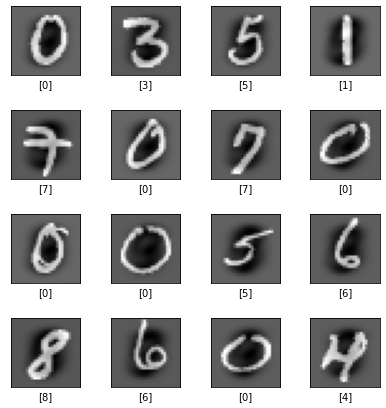

In [3]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
np.random.seed(42)
random_image_indices = np.random.randint(0, X_train.shape[0], (16))
fig, ax = plt.subplots(4, 4, figsize=(7, 7))
plt.subplots_adjust(wspace=0.1, hspace = 0.5 )
for i, axi in enumerate(ax.flat):
  i = random_image_indices[i]
  axi.imshow(X_train[i].reshape(28, 28), cmap = 'gray')
  axi.set(xticks=[], yticks=[])
  axi.set_xlabel(y_train_unencoded[i])

In [4]:
one_hot_encoder = OneHotEncoder(sparse=False)

In [5]:
y_train = one_hot_encoder.fit_transform(y_train_unencoded)
y_test = one_hot_encoder.fit_transform(y_test_unencoded)

In [6]:
type(y_train)

numpy.ndarray

In [7]:
y_train.shape

(48000, 10)

## Building up parts of our classifier

**Activation functions**

In [8]:
def relu(z, derive=False):
    """
    Arguments:
    z -- A scalar or numpy array.
    Return:
    relu func applied to each element of z
    """
    if (derive == True):
      diff_x = np.where(z<0, 0, 1)
      return diff_x
    return np.maximum(0, z)

def softmax(z):
    """
    returns computed probabilitites for each element in batch separately
    input: (N, 10)
    output: (N, 10)
    """
    a=np.array(z)
    temp_exp = np.exp(z)
    soft_maxed = temp_exp/np.sum(temp_exp, axis=0)
    return soft_maxed

**Notes about the Neural Network** 
*   Input size is (784,) because 28x28 = 784
*   Output size will be 10, each element represeting probability of the image representing that digit
*   Size of the hidden layer is a hyperparameter



**Initialize the layers weights**

Generally, we follow the convention that weights are drawn from a standard normal distribution, while the bias vectors are initialized to zero. But you can try everything out :)

In [9]:

def init_params(hidden_nodes):
    """
    ideally it should take the size of all the layers and 
    should return the initialized weights.
    """
    input_nodes=784
    output_classes=10
    weights = {
                'w1' : np.random.randn(hidden_nodes, input_nodes)*np.sqrt(1/hidden_nodes),   # Xavier initialisation 
                'b1' : np.zeros((hidden_nodes, 1), dtype=float),
                'w2' : np.random.randn(output_classes, hidden_nodes)*np.sqrt(1/output_classes) ,
                'b2' : np.zeros((output_classes, 1), dtype=float)
              }          

    return weights          



**Forward Propagation**

In [10]:
def forward_propg(X, weights):
    """
    X: input data
    returns: logits, output of each layer z1,z2,a1,a2
    """

    int_layer = np.matmul(weights['w1'], X.T) + weights['b1']
    int_layer_out = relu(int_layer)
    final_layer = np.matmul(weights['w2'], int_layer_out) + weights['b2']
    final_layer_out = relu(final_layer)
    state = {'a1':int_layer_out, 'a2':final_layer_out, 'z1':int_layer, 'z2':final_layer}
    # state is similar to cache, which holds the current values for backprop
    return state


**Backward Propagation**


You may use stochastic gradient descent or batch gradient descent here. Feel free to use any loss function.

In [11]:
def backward_propg(weights, X, y, state):
    """
    should update the weights and return updated weights
    """
    batch_size = y.shape[0]
    dz2 = state['z2'] - y.T
    dw2 = (1./batch_size)*np.matmul(dz2, state['a1'].T)
    db2 = (1./batch_size)*np.sum(dz2, axis=1, keepdims=True)

    da1 = np.matmul(weights['w2'].T, dz2.reshape(10, 48000))
    dz1 = da1*relu(state['z1'], derive=True)
    dw1 = (1./batch_size) * np.matmul(dz1, X)
    db1 = (1./batch_size) * np.sum(dz1, axis=1, keepdims=True)

    gradients = {'w1':dw1, 'w2':dw2, 'b1':db1, 'b2':db2}
    return gradients

In [12]:
def cost_func(state, y):
    """
    calculate loss to check whether it is decreasing at each epoch or not
    one can return this in backward propagation as well
    """
    #using softmax loss
    final_output = state['a2']
    final_difference = softmax(final_output) - y.T
    loss = -np.log(np.abs(final_difference))
    summed_loss = np.sum(loss)/48000
    return summed_loss


In [13]:
weights = init_params(256)


## Integrate everything

In [14]:
def train(X, y, hidden_nodes, epochs=1000, lr=1e-5):
    """
    hidden_nodes: no. of nodes in hidden layer

    should return the updated optimize weights.
    """
    # initialize weights.
    weights = init_params(hidden_nodes)
    

    for i in range(epochs):
      # forward propagation
      state = forward_propg(X_train, weights)

      # print cost at every 100 or so iterations
      print(f"Cost function in {i} epoch is: {cost_func(state, y_train)} units " )
        
      # backward propagation
      grads = backward_propg(weights, X_train, y_train, state)

      weights['w1']-= lr*grads['w1']
      weights['w2']-= lr*grads['w2']
      weights['b1']-= lr*grads['b1']
      weights['b2']-= lr*grads['b2']


    return weights   
        
        

In [15]:
trained_weights = train(X_train, y_train, 256, 3000, 0.01)

Cost function in 0 epoch is: 25.270871158779865 units 
Cost function in 1 epoch is: 24.206161256940394 units 
Cost function in 2 epoch is: 23.65934063977541 units 
Cost function in 3 epoch is: 23.326700451134514 units 
Cost function in 4 epoch is: 23.104786984005617 units 
Cost function in 5 epoch is: 22.949287279382172 units 
Cost function in 6 epoch is: 22.836518702040415 units 
Cost function in 7 epoch is: 22.75238586154176 units 
Cost function in 8 epoch is: 22.68775966501003 units 
Cost function in 9 epoch is: 22.63689033500015 units 
Cost function in 10 epoch is: 22.595837321108366 units 
Cost function in 11 epoch is: 22.56198073983839 units 
Cost function in 12 epoch is: 22.53346864696126 units 
Cost function in 13 epoch is: 22.50901251910488 units 
Cost function in 14 epoch is: 22.48774887719947 units 
Cost function in 15 epoch is: 22.468971645207308 units 
Cost function in 16 epoch is: 22.452263988225198 units 
Cost function in 17 epoch is: 22.437212942930195 units 
Cost funct

In [16]:
def predict(X, updated_weights):
    """
    returns the prediction in [0,9] for each element in X
    """
    predictions = forward_propg(X, updated_weights)
    final_output_probs = predictions['a2']
    predicted_values = np.argmax(final_output_probs.T, axis = 1) 
    return predicted_values   
    

In [17]:
predictions_test_data = predict(X_test, trained_weights)

In [18]:
predictions_test_data

array([7, 4, 4, ..., 0, 3, 4])

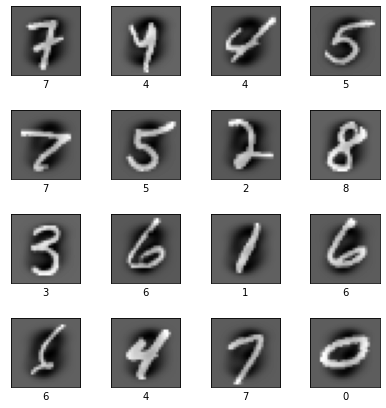

In [19]:
fig, ax = plt.subplots(4, 4, figsize=(7, 7))
plt.subplots_adjust(wspace=0.1, hspace = 0.5 )
for i, axi in enumerate(ax.flat):
 # i = predictions_test_data[i]
  axi.imshow(X_test[i].reshape(28, 28), cmap = 'gray')
  axi.set(xticks=[], yticks=[])
  axi.set_xlabel(predictions_test_data[i])

In [20]:
def accuracy(predictions, y):
    """
    prints % accuracy
    """
    anomaly_array = predictions - y.reshape(12000, )
    misprediction_count = np.count_nonzero(anomaly_array)
    total_array_count = len(y)
    error = misprediction_count/total_array_count
    return (1-error)

In [21]:
print(accuracy(predictions_test_data, y_test_unencoded))

0.8420833333333333


### Save as pickle

In [23]:
import pickle
import random
from google.colab import files

roll_num = "200070077" # enter ldap
hidden_dim = 256  # replace with your own hidden dimension

model_dict = {
    'z': hidden_dim, # hidden dimension of your model
    'layer_0_wt': trained_weights['w1'].T, # layer 0 weight (784, z)
    'layer_0_bias': trained_weights['b1'], # layer 0 bias (z, 1)
    'layer_1_wt': trained_weights['w2'].T, # layer 1 weight (z, 10)
    'layer_1_bias': trained_weights['b2'] # layer 1 bias (10, 1)
}

assert model_dict['layer_0_wt'].shape == (784, hidden_dim)
assert model_dict['layer_0_bias'].shape == (hidden_dim, 1)
assert model_dict['layer_1_wt'].shape == (hidden_dim, 10)
assert model_dict['layer_1_bias'].shape == (10, 1)

with open(f'model_{roll_num}.pkl', 'wb') as f:
    pickle.dump(model_dict, f)
    files.download(f'model_{roll_num}.pkl') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>